In [ ]:
!pip install yfinance pandas numpy matplotlib seaborn pandas-ta prophet


In [2]:
import yfinance as yf
import pandas as pd

# List of companies (tickers)
tickers = ['AAPL', 'GOOGL', 'AMZN']

# Create a directory to save data
import os
os.makedirs("data", exist_ok=True)

# Download stock price data
for ticker in tickers:
    stock_data = yf.download(ticker, start="2015-01-01", end="2025-01-01", interval="1d")
    stock_data.to_csv(f"data/{ticker}_prices.csv")  # Save to CSV
    print(f"{ticker} stock data downloaded and saved!")


[*********************100%***********************]  1 of 1 completed


AAPL stock data downloaded and saved!


[*********************100%***********************]  1 of 1 completed


GOOGL stock data downloaded and saved!


[*********************100%***********************]  1 of 1 completed

AMZN stock data downloaded and saved!


In [3]:
# Load stock data for one company
df = pd.read_csv("data/AAPL_prices.csv", index_col="Date", parse_dates=True)
print(df.head())


                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.347174  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.661283  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.663496  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  23.995316  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  24.917274  237458000


In [4]:
import pandas_ta as ta

# Calculate technical indicators
df["SMA"] = ta.sma(df["Close"], length=20)  # Simple Moving Average
df["EMA"] = ta.ema(df["Close"], length=20)  # Exponential Moving Average
df["RSI"] = ta.rsi(df["Close"], length=14)  # Relative Strength Index
df.ta.bbands(length=20, append=True)        # Bollinger Bands

# Drop NaN values introduced by indicator calculations
df = df.dropna()

print(df.head())


                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2015-01-30  29.600000  30.000000  29.212500  29.290001  26.090868  334982000   
2015-02-02  29.512501  29.792500  29.020000  29.657499  26.418224  250956400   
2015-02-03  29.625000  29.772499  29.402500  29.662500  26.422684  207662800   
2015-02-04  29.625000  30.127501  29.577499  29.889999  26.625334  280598800   
2015-02-05  30.004999  30.057501  29.812500  29.985001  26.815367  168984800   

                  SMA        EMA        RSI  BBL_20_2.0  BBM_20_2.0  \
Date                                                                  
2015-01-30  27.660375  27.660375  63.366920   25.909342   27.660375   
2015-02-02  27.776625  27.850578  65.630046   25.830280   27.776625   
2015-02-03  27.931625  28.023142  65.661135   25.904646   27.931625   
2015-02-04  28.097875  28.200938  67.118240   26.002260   28.097875   
2015-02-05  2

In [5]:
from sklearn.ensemble import IsolationForest

# Prepare feature set
features = df[["Close", "SMA", "EMA", "RSI"]]

# Initialize and train Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
df["Anomaly"] = model.fit_predict(features)

# Identify anomalies (marked as -1)
anomalies = df[df["Anomaly"] == -1]

print(f"Number of anomalies detected: {len(anomalies)}")


Number of anomalies detected: 25


09:52:28 - cmdstanpy - INFO - Chain [1] start processing
09:52:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Dark_Coder\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Dark_Coder\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


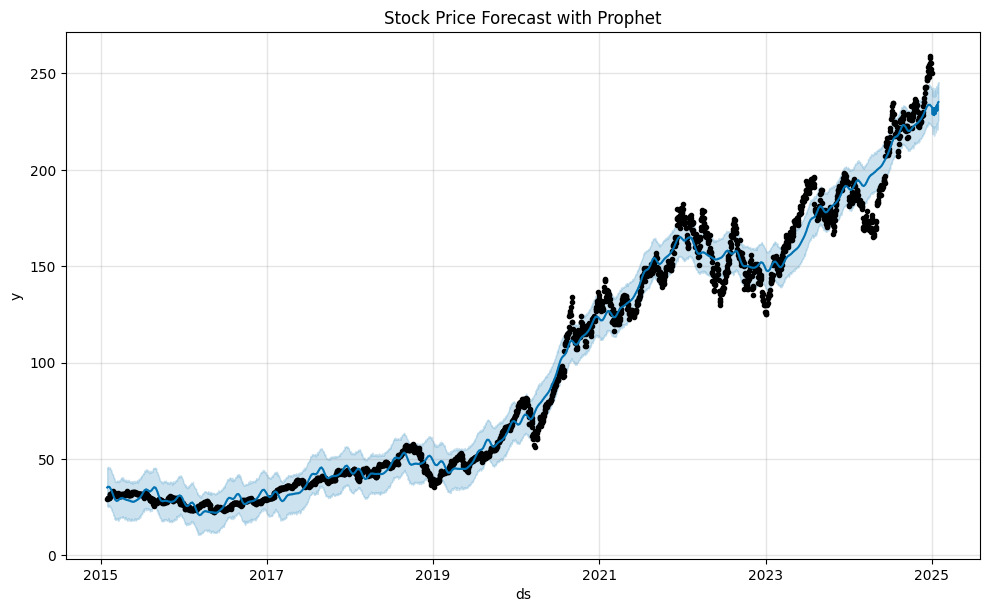

In [8]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare data for Prophet
df_prophet = df[["Close"]].reset_index()
df_prophet.columns = ["ds", "y"]

# Train Prophet model
model = Prophet()
model.fit(df_prophet)

# Forecast future data
future = model.make_future_dataframe(periods=30)  # Extend data by 30 days
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("Stock Price Forecast with Prophet")
plt.show()


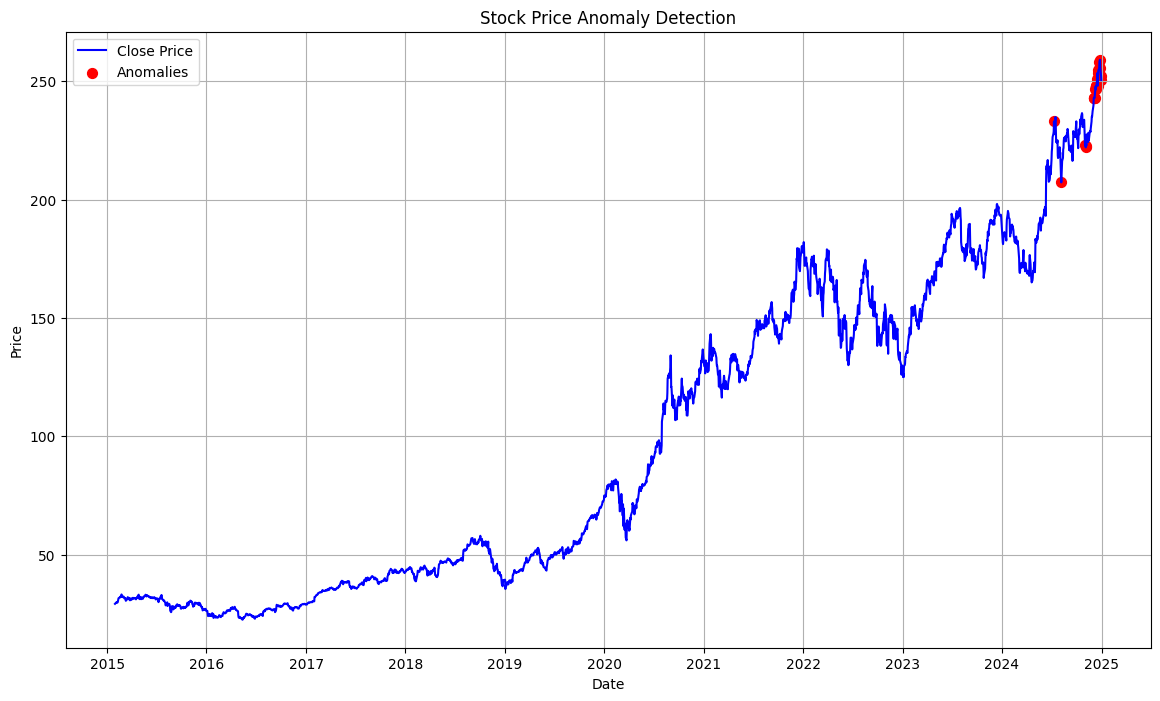

In [9]:
import matplotlib.pyplot as plt

# Plot the stock prices and mark anomalies
plt.figure(figsize=(14, 8))
plt.plot(df.index, df["Close"], label="Close Price", color="blue", linewidth=1.5)
plt.scatter(anomalies.index, anomalies["Close"], color="red", label="Anomalies", s=50)
plt.title("Stock Price Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


In [11]:
# Save anomalies to CSV
anomalies.to_csv("results/AAPL_anomalies.csv")

# Save plot
plt.savefig("results/AAPL_anomaly_plot.png")


<Figure size 640x480 with 0 Axes>